In [5]:
import requests
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import geopandas as gpd
import pandas as pd
import json
from typing import List
from rasterstats import zonal_stats
import rasterio

### Get T3 Information

In [7]:
# Functions
def returning_unit(name):
    """
    Extracts the numeric part from the end of a string.

    Parameters:
    name (str): The string from which to extract the numeric part.

    Returns:
    int: The numeric part of the string as an integer, if present.
         If no numeric part is found, the function returns None.
    """
    for i in range(len(name)):
        case = name[i:]
        if case.isnumeric():
            return int(case)

# Adjusted method to fetch paginated data
def fetch_paginated_data(endpoint):
    """
    Fetches data from a paginated API endpoint.

    Parameters:
    endpoint (str): The URL of the API endpoint.

    Returns:
    list: A list of all data items fetched from the API.
    """
    page_size = 500
    current_page = 0
    total_pages = 1
    all_data = []

    while current_page < total_pages:
        url = f"{endpoint}&pageSize={page_size}&page={current_page}"
        response = requests.get(url)
        data = response.json()
        all_data.extend(data["result"]["data"])

        # Update metadata for pagination
        current_page += 1
        total_pages = data["metadata"]["pagination"]["totalPages"]

    return all_data

# #### Input the Trial_ID
trial_id_input = input("Enter trial IDs, separated by commas (e.g., 9325,9326,9358,9427): ")
trial_ids = [int(id.strip()) for id in trial_id_input.split(',')]

#Create Ouput directory
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)


# --- Creating list with the initial results
all_dataframes_M = []

for trial_id in tqdm(trial_ids, desc="Processing your request"):
    trial_dir = os.path.join(output_dir, f"trial_{trial_id}")
    os.makedirs(trial_dir, exist_ok=True)

    api_base_url = "https://wheat-sandbox.triticeaetoolbox.org"
    #api_base_url = "https://wheatcap.triticeaetoolbox.org"   #uncomment as needed

    try:
        # Fetching data from the studies endpoint
        endpoint_path_studies = f"/brapi/v2/studies?studyDbId={trial_id}"
        data_studies = fetch_paginated_data(f"{api_base_url}{endpoint_path_studies}")

        # Fetching data from the observationunits endpoint
        endpoint_path_observationunits = f"/brapi/v2/observationunits?studyDbId={trial_id}"
        data_observationunits = fetch_paginated_data(f"{api_base_url}{endpoint_path_observationunits}")
    except Exception as e:
        print(f"Error fetching data for trial ID {trial_id}: {e}")
        continue

    # --- Creating list with the initial results
    M = []

    # --- Defining list of variables of interest
    variables = ["germplasmDbId", "germplasmName", "locationDbId", "locationName",
                 "observationUnitDbId", "observationUnitName", "programDbId",
                 "programName", "studyDbId", "studyName", "trialDbId", "trialName"]
    variables2 = ["levelName", "levelCode", "levelOrder"]
    variables3 = ["positionCoordinateX", "positionCoordinateY"]

    for unit in data_observationunits:
        partial_list = []
        # --- Looping over variables
        for var in variables:
            # --- Adding element to the partial list
            partial_list.append(unit[var])
        # --- Looping over variables
        for var in variables2:
            # --- Adding elements
            partial_list.append(unit["observationUnitPosition"]["observationLevel"][var])
        # --- Looping over variables
        for var in variables3:
            # --- Adding elements
            partial_list.append(unit["observationUnitPosition"][var])
        M.append(partial_list)
    # --- Changing M_df to a dataframe
    M_df = pd.DataFrame(M, columns = variables + variables2 + variables3)
    all_dataframes_M.append(M_df)

    # Assuming all study data rows have the same "studyType",
    # we can extract the first one and use it for all entries.
    study_type = data_studies[0]["studyType"]
    M_df["studyType"] = study_type

    # Extract plot numbers using the returning_unit function
    M_df["Plot"] = [returning_unit(var) for var in M_df["observationUnitName"]]
    M_df = M_df.sort_values(by="Plot").reset_index(drop=True)

    # Slicing the data
    Msliced = M_df[M_df["studyDbId"] == str(trial_id)].reset_index(drop=True)
    M_df.rename(columns={'germplasmName': 'Name',
                      'observationUnitDbId': 'PLOT_ID',
                      'positionCoordinateX': 'X',
                      'positionCoordinateY': 'Y',
                      'Plot': 'PLOT_NO'}, inplace=True)

    # Output 1 for Plots
    M2 = M_df[['Name', 'PLOT_ID', 'studyDbId', 'studyName', 'X', 'Y', 'PLOT_NO', 'studyType' ]].copy()
    M2.rename(columns={'X': 'Column', 'Y': 'Row', 'studyType': 'TrialType'}, inplace=True)
    M2.to_csv(os.path.join(trial_dir, f"Plot_info_{trial_id}.csv"), index=False)
    # Use M2 directly
    t3 = M2.copy()
    
    # --- Spatial layout - Output 3 
    M3 = M_df[['PLOT_ID', 'X', 'Y', 'PLOT_NO']].copy()
    M3.rename(columns={'X': 'Column', 'Y': 'Row'}, inplace=True)
    
    # Ensure numeric types
    M3["Row"] = pd.to_numeric(M3["Row"], errors="coerce")
    M3["Column"] = pd.to_numeric(M3["Column"], errors="coerce")
    M3["PLOT_NO"] = pd.to_numeric(M3["PLOT_NO"], errors="coerce")
    
    # Drop rows with missing coordinates
    M3 = M3.dropna(subset=["Row", "Column", "PLOT_NO"])
    
    if M3.empty:
        print(f"⚠️ No coordinate data found for trial ID {trial_id}. Skipping test3.")
        continue
    
    # Get sorted unique coordinates
    row_vals = sorted(M3["Row"].unique(), reverse=True)
    col_vals = sorted(M3["Column"].unique())
    
    # Create an empty DataFrame for layout (float type)
    D = pd.DataFrame(index=row_vals, columns=col_vals, dtype=float)
    
    # Fill layout with floating PLOT_NO values
    for _, r in M3.iterrows():
        D.loc[r["Row"], r["Column"]] = float(r["PLOT_NO"])
    
    # Optionally fill empty cells with NaN (already default) or 0
    # D = D.fillna(0.0)
    
    # Save inside the trial directory
    test3_path = os.path.join(trial_dir, f"T3_Layout_{trial_id}.csv")
    D = D.map(lambda x: f"{int(x)}" if isinstance(x, (int, float)) and not pd.isna(x) else x)
    D.to_csv(test3_path, index=False)

    t3_plot = D.copy()
    
    print(f"✅ T3_Layout_{trial_id}.csv saved successfully in {trial_dir}")

    # --- Printing to check
    D
    print(f"Download and save completed for trial ID {trial_id}")

# Combine all dataframes
final_M = pd.concat(all_dataframes_M, ignore_index=True)

Enter trial IDs, separated by commas (e.g., 9325,9326,9358,9427):  9411


Processing your request: 100%|██████████| 1/1 [00:07<00:00,  7.52s/it]

✅ T3_Layout_9411.csv saved successfully in output/trial_9411
Download and save completed for trial ID 9411


### Merge the PBE Boundary Attribute and T3 data

In [8]:
# === Step 1: Read the GeoJSON file ===
geojson_path = "cornell_2022_boundary.geojson"
pbe = gpd.read_file(geojson_path)

# === Step 2: Parse 'properties' JSON strings into actual columns ===
pbe_props = pbe['properties'].apply(json.loads)
props_df = pd.json_normalize(pbe_props)
pbe_expanded = pd.concat([pbe.drop(columns='properties'), props_df], axis=1)

# Rename to match T3 structure
pbe_expanded = pbe_expanded.rename(columns={'row': 'Row', 'col': 'Column'})

# Ensure integer types for merge
pbe_expanded['Row'] = pbe_expanded['Row'].astype(int)
pbe_expanded['Column'] = pbe_expanded['Column'].astype(int)

# Preview attribute columns
#print("GeoJSON columns:", list(pbe_expanded.columns))

#preview
pbe_expanded.head()

,layer_name,layer_id,is_active,project_id,flight_id,data_product_id,feature_id,geometry,Column,Row
0,cornell_2022_boundary.geojson,wV0q_oFUE8k,True,b4ab960b-9629-46d7-881c-5612fd5ee0dd,None,None,0b2fe63d-8d6c-4f8d-b32b-3246329ca84b,"POLYGON ((-76.43994 42.44634, -76.43993 42.446...",4,1
1,cornell_2022_boundary.geojson,wV0q_oFUE8k,True,b4ab960b-9629-46d7-881c-5612fd5ee0dd,None,None,23d4b157-af9c-4ab2-a825-99ddab584b8e,"POLYGON ((-76.43993 42.44635, -76.43993 42.446...",5,1
2,cornell_2022_boundary.geojson,wV0q_oFUE8k,True,b4ab960b-9629-46d7-881c-5612fd5ee0dd,None,None,830f21ca-96b6-4eec-b0fc-d17276ada3d1,"POLYGON ((-76.43993 42.44636, -76.43992 42.446...",6,1
3,cornell_2022_boundary.geojson,wV0q_oFUE8k,True,b4ab960b-9629-46d7-881c-5612fd5ee0dd,None,None,475e0354-8d55-4fd3-89d6-8509bfff7e56,"POLYGON ((-76.43992 42.44637, -76.43991 42.446...",7,1
4,cornell_2022_boundary.geojson,wV0q_oFUE8k,True,b4ab960b-9629-46d7-881c-5612fd5ee0dd,None,None,6fa877bd-3f35-4b06-9019-97534aaef947,"POLYGON ((-76.43991 42.44638, -76.43991 42.446...",8,1


### Before Rotation

### Plot Maps - PBE

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_spatial_layout(df, row_col=('Row', 'Column'), title="Spatial Layout", 
                        cmap='Greys', figsize=(15,15), fontsize=8, reverse_rows=True):
    """
    Plots a spatial layout grid based on row and column coordinates.

    Parameters:
    - df: DataFrame containing at least Row and Column columns.
    - row_col: tuple, names of the row and column columns in df.
    - title: string, title of the plot.
    - cmap: string, colormap for the grid.
    - figsize: tuple, figure size.
    - fontsize: int, font size for cell annotations.
    - reverse_rows: bool, if True, row numbers are reversed for plotting (Row 1 at bottom)
    """

    # Copy relevant columns
    M = df[[row_col[1], row_col[0]]].copy()
    M[row_col[0]] = pd.to_numeric(M[row_col[0]], errors='coerce')
    M[row_col[1]] = pd.to_numeric(M[row_col[1]], errors='coerce')
    M = M.dropna(subset=[row_col[0], row_col[1]])

    # Unique sorted coordinates
    row_vals = sorted(M[row_col[0]].unique(), reverse=reverse_rows)
    col_vals = sorted(M[row_col[1]].unique())

    # Create empty layout DataFrame
    layout = pd.DataFrame(index=row_vals, columns=col_vals, dtype=float)

    # Fill layout with 1 to indicate presence
    for _, r in M.iterrows():
        layout.loc[r[row_col[0]], r[row_col[1]]] = 1

    # Replace NaN with blank for CSV or plotting convenience
    layout_display = layout.map(lambda x: int(x) if pd.notna(x) else "")

    # Convert for plotting
    values = layout_display.replace("", np.nan).values.astype(float)

    # Plot
    plt.figure(figsize=figsize)
    plt.imshow(values, cmap=cmap, origin='lower')

    # Annotate cells
    for i in range(values.shape[0]):
        for j in range(values.shape[1]):
            if not np.isnan(values[i, j]):
                plt.text(j, i,
                         f"R{layout_display.index[i]}-C{layout_display.columns[j]}",
                         ha='center', va='center',
                         fontsize=fontsize, fontweight='bold', color='black')

    # Tick labels
    plt.xticks(np.arange(values.shape[1]), layout_display.columns)
    plt.yticks(np.arange(values.shape[0]), layout_display.index)

    # Grid lines
    plt.gca().set_xticks(np.arange(-.5, values.shape[1], 1), minor=True)
    plt.gca().set_yticks(np.arange(-.5, values.shape[0], 1), minor=True)
    plt.grid(which='minor', color='k', linestyle='-', linewidth=0.8)
    plt.tick_params(which='minor', bottom=False, left=False)

    plt.title(title, fontsize=14, pad=15)
    plt.tight_layout()
    plt.show()

    return layout_display  # return DataFrame in case you want to save/export

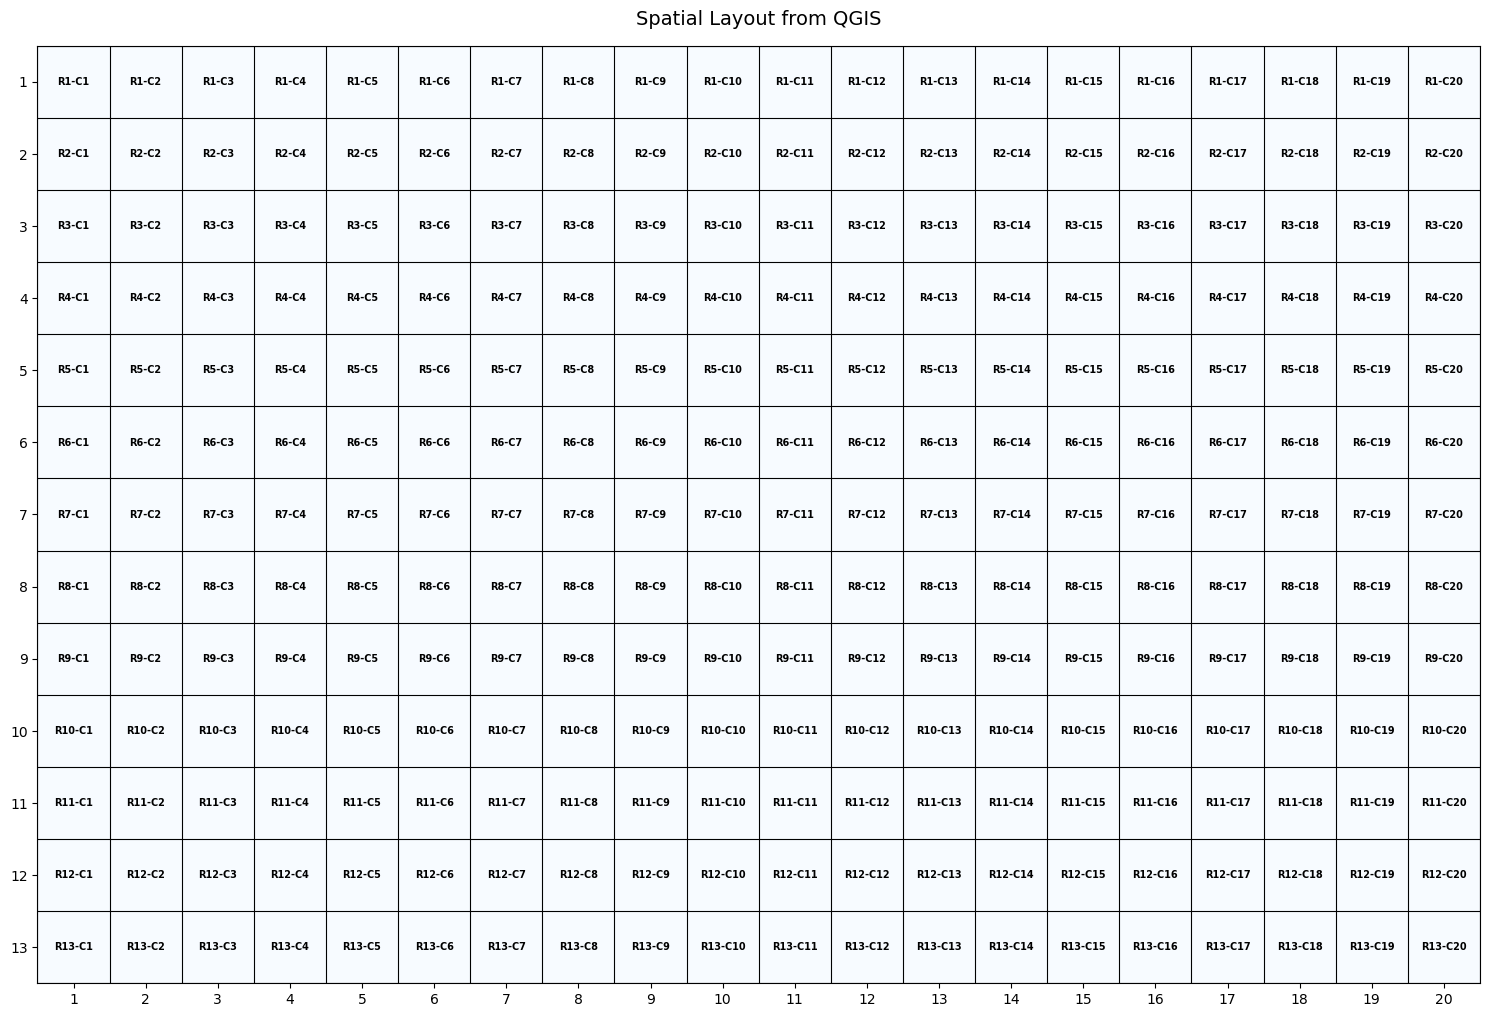

In [14]:
layout_df = plot_spatial_layout(pbe_expanded, title="Spatial Layout from QGIS", cmap='Blues', fontsize=7)

In [15]:
# === Step 3: Select only necessary columns from T3 ===
# Make sure 'Row' and 'Column' are integers to avoid matching issues
t3_subset = t3[['Name', 'Row', 'Column', 'PLOT_ID', 'PLOT_NO' ]].copy()
t3_subset['Row'] = t3_subset['Row'].astype(int)
t3_subset['Column'] = t3_subset['Column'].astype(int)

t3_subset.head()

,Name,Row,Column,PLOT_ID,PLOT_NO
0,ERIE,1,1,1380641,3001
1,MEDINA-264,1,2,1380563,3002
2,NY11013-10-15-1312,1,3,1380716,3003
3,NY11014-9-25-1319,1,4,1380799,3004
4,NY99056-161-515,1,5,1380774,3005


### Plot Maps - T3

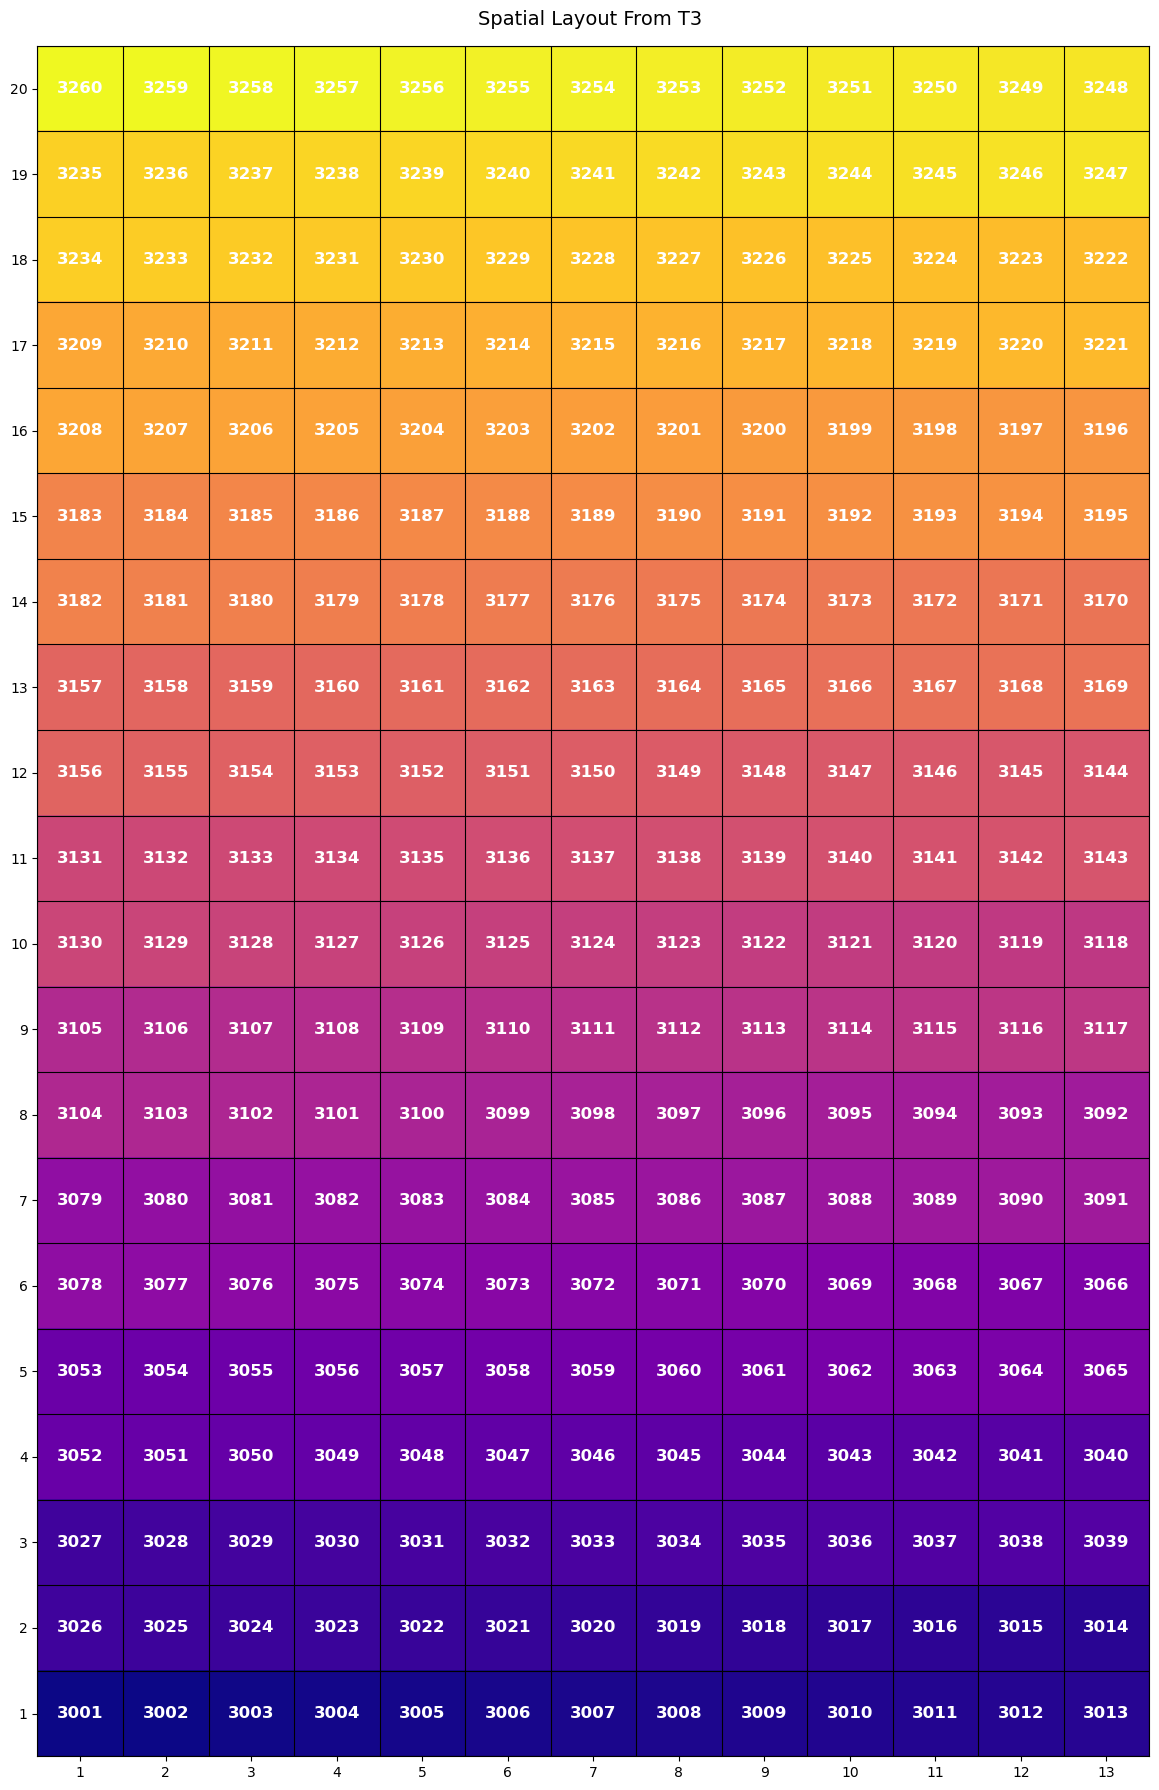

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ensure numeric values
t3_plot = t3_plot.apply(pd.to_numeric, errors='coerce')
values = t3_plot.values

plt.figure(figsize=(18, 18))
im = plt.imshow(values, cmap='plasma', origin='lower')  # origin='lower' is correct

# Annotate cells
for i in range(values.shape[0]):
    for j in range(values.shape[1]):
        val = values[i, j]
        if not np.isnan(val):  # Avoid writing NaN
            plt.text(j, i, f"{int(val)}", ha='center', va='center',
                     color='white', fontsize=12, fontweight='bold')

# Tick labels
plt.xticks(np.arange(values.shape[1]), D.columns)
plt.yticks(np.arange(values.shape[0]), D.index)

# Flip y-axis to match DataFrame order if needed
plt.gca().invert_yaxis()  # <--- This flips the rows so first row is at top

# Grid
plt.gca().set_xticks(np.arange(-.5, values.shape[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-.5, values.shape[0], 1), minor=True)
plt.grid(which='minor', color='k', linestyle='-', linewidth=0.8)
plt.tick_params(which='minor', bottom=False, left=False)

# Colorbar
#plt.colorbar(im, fraction=0.046, pad=0.04)

plt.title("Spatial Layout From T3 ", fontsize=14, pad=15)
plt.tight_layout()
plt.show()

In [18]:
# === Step 3: Select only necessary columns from T3 ===
# Make sure 'Row' and 'Column' are integers to avoid matching issues
pbe_subset = pbe_expanded[['Row', 'Column', 'geometry', 'project_id', 'feature_id']].copy()
pbe_subset['Row'] = pbe_subset['Row'].astype(int)
pbe_subset['Column'] = pbe_subset['Column'].astype(int)
 
# Swap Row and Column in GeoJSON to match T3 
pbe_fixed = pbe_subset.rename(columns={'Row':'Column', 'Column':'Row'})

# Ensure integer type
pbe_fixed['Row'] = pbe_fixed['Row'].astype(int)
pbe_fixed['Column'] = pbe_fixed['Column'].astype(int)

pbe_fixed.head()

,Column,Row,geometry,project_id,feature_id
0,1,4,"POLYGON ((-76.43994 42.44634, -76.43993 42.446...",b4ab960b-9629-46d7-881c-5612fd5ee0dd,0b2fe63d-8d6c-4f8d-b32b-3246329ca84b
1,1,5,"POLYGON ((-76.43993 42.44635, -76.43993 42.446...",b4ab960b-9629-46d7-881c-5612fd5ee0dd,23d4b157-af9c-4ab2-a825-99ddab584b8e
2,1,6,"POLYGON ((-76.43993 42.44636, -76.43992 42.446...",b4ab960b-9629-46d7-881c-5612fd5ee0dd,830f21ca-96b6-4eec-b0fc-d17276ada3d1
3,1,7,"POLYGON ((-76.43992 42.44637, -76.43991 42.446...",b4ab960b-9629-46d7-881c-5612fd5ee0dd,475e0354-8d55-4fd3-89d6-8509bfff7e56
4,1,8,"POLYGON ((-76.43991 42.44638, -76.43991 42.446...",b4ab960b-9629-46d7-881c-5612fd5ee0dd,6fa877bd-3f35-4b06-9019-97534aaef947


### After Rotation and Swap

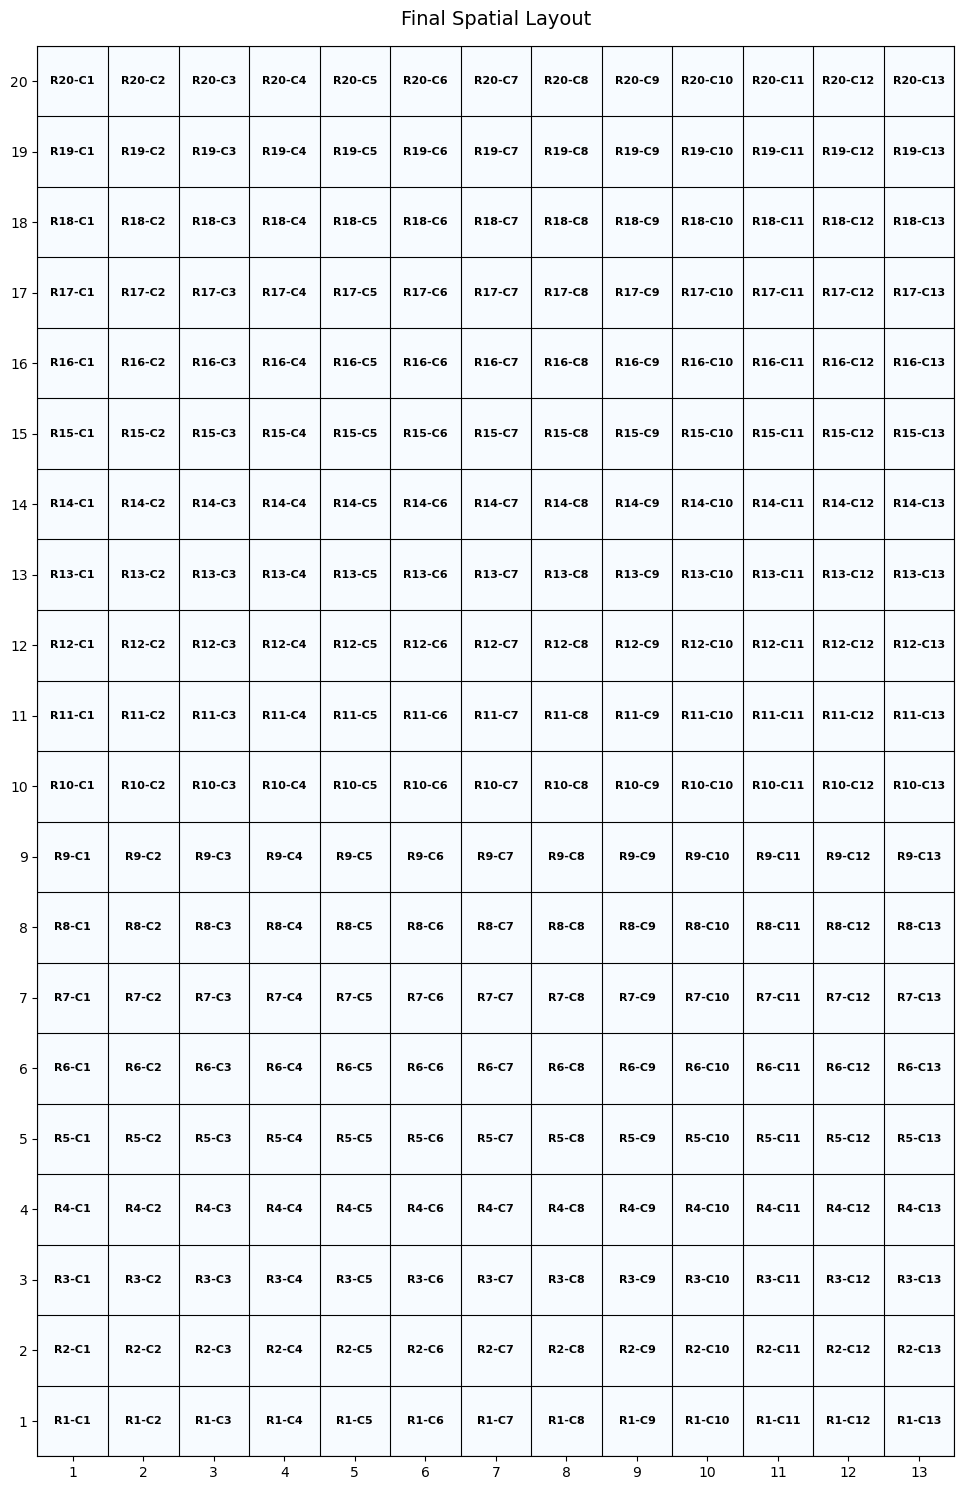

In [22]:
merged_final = plot_spatial_layout(pbe_fixed, title="Final Spatial Layout", cmap='Blues', fontsize=8, reverse_rows=False)

In [13]:
# === Step 4: Merge datasets ===
# Merge, keeping geometry
merged_gdf = pbe_fixed.merge(
    t3_subset, 
    on=['Row', 'Column'], 
    how='left'
)

# Quality Check: Check merge results
print("Total rows:", len(merged_gdf))
print("Matched rows:", merged_gdf['PLOT_ID'].notna().sum())
print("Unmatched rows:", merged_gdf['PLOT_ID'].isna().sum())

Total rows: 260
Matched rows: 260
Unmatched rows: 0


In [14]:
merged_gdf.head()

,Column,Row,geometry,project_id,feature_id,Name,PLOT_ID,PLOT_NO
0,1,4,"POLYGON ((-76.43994 42.44634, -76.43993 42.446...",b4ab960b-9629-46d7-881c-5612fd5ee0dd,0b2fe63d-8d6c-4f8d-b32b-3246329ca84b,NY12300-1-6-07-1436,1380725,3052
1,1,5,"POLYGON ((-76.43993 42.44635, -76.43993 42.446...",b4ab960b-9629-46d7-881c-5612fd5ee0dd,23d4b157-af9c-4ab2-a825-99ddab584b8e,NY12311-1-30-10-1452,1380706,3053
2,1,6,"POLYGON ((-76.43993 42.44636, -76.43992 42.446...",b4ab960b-9629-46d7-881c-5612fd5ee0dd,830f21ca-96b6-4eec-b0fc-d17276ada3d1,NY15134-01-02-01-1823,1380746,3078
3,1,7,"POLYGON ((-76.43992 42.44637, -76.43991 42.446...",b4ab960b-9629-46d7-881c-5612fd5ee0dd,475e0354-8d55-4fd3-89d6-8509bfff7e56,NY16095-01-04-1934,1380609,3079
4,1,8,"POLYGON ((-76.43991 42.44638, -76.43991 42.446...",b4ab960b-9629-46d7-881c-5612fd5ee0dd,6fa877bd-3f35-4b06-9019-97534aaef947,NY15116-01-06-01-1804,1380607,3104


In [15]:
# === Step 6: Export to GeoJSON ===
# Export to GeoJSON
merged_gdf.to_file("cornell_2022_out.geojson", driver="GeoJSON")
print("Saved merged GeoJSON as 'cornell_2022_out.geojson'")

Saved merged GeoJSON as 'cornell_2022_out.geojson'


#### Connect to D2S

In [17]:
import os
import leafmap
from datetime import date
from d2spy.workspace import Workspace
import d2s_env

d2s_env is being imported


In [18]:
# Example of connecting to a workspace for a local D2S instance
workspace = Workspace.connect("https://ps2.d2s.org")

In [19]:
# Check for API key
api_key = workspace.api_key
if not api_key:
    print("No API key. Please request one from the D2S profile page and re-run this cell.")
else:
    os.environ["D2S_API_KEY"] = api_key
    
os.environ["TITILER_ENDPOINT"] = "https://tt.d2s.org"

In [20]:
# Change the search term in `.filter_by_title` to match your project
project = workspace.get_projects().filter_by_title("cornell wheat")
for i, proj in enumerate(project):
    print(i, proj)

0 Project(title='2025 Cornell Wheat', description='USDA WheatCAP Project - CornellMaster_2025_McGowan: Cornell 2025 Winter Wheat Master Nursery', start_date=datetime.date(2024, 9, 17), end_date=datetime.date(2025, 7, 16))
1 Project(title='2023 Cornell Wheat', description='USDA WheatCAP Project - Cornell University 2023 Winter Wheat Master Nursery trial at Ithaca, NY - McGowan', start_date=datetime.date(2022, 10, 11), end_date=datetime.date(2023, 6, 29))
2 Project(title='2024 Cornell Wheat', description='USDA WheatCAP Project - Cornell University 2024 Winter Wheat Master Nursery trial at Ithaca, NY - Helfer', start_date=datetime.date(2023, 10, 11), end_date=datetime.date(2024, 7, 8))
3 Project(title='2022 Cornell Wheat', description='USDA WheatCAP Project - Cornell University 2022 WWMASTER2022ACCT3 trial at Ithaca, NY - Helfer', start_date=datetime.date(2021, 10, 21))


In [21]:
project = project[3]

In [22]:
# Change the date range in filter_by_date to match the acquistion date of the flight in your project 
start_date = date(2022,4,20) 
end_date = date(2022,7,15) 
flights = project.get_flights().filter_by_date(start_date,end_date) 
for i, flight in enumerate(flights): 
    print(i,flight) 

0 Flight(acquisition_date='2022-05-25', name='', altitude=120.0, side_overlap=60.0, forward_overlap=75.0, sensor='Multispectral', platform='Phantom_4')
1 Flight(acquisition_date='2022-06-20', name='', altitude=120.0, side_overlap=60.0, forward_overlap=75.0, sensor='Multispectral', platform='Phantom_4')
2 Flight(acquisition_date='2022-04-20', name='', altitude=120.0, side_overlap=60.0, forward_overlap=75.0, sensor='Multispectral', platform='M300')
3 Flight(acquisition_date='2022-04-20', name=None, altitude=120.0, side_overlap=60.0, forward_overlap=75.0, sensor='RGB', platform='Phantom_4')
4 Flight(acquisition_date='2022-05-11', name=None, altitude=120.0, side_overlap=60.0, forward_overlap=75.0, sensor='RGB', platform='Phantom_4')
5 Flight(acquisition_date='2022-07-15', name='', altitude=120.0, side_overlap=60.0, forward_overlap=75.0, sensor='Multispectral', platform='Phantom_4')
6 Flight(acquisition_date='2022-04-30', name='', altitude=120.0, side_overlap=60.0, forward_overlap=75.0, sen

In [23]:
flight = flights[9]

In [24]:
data_products = flight.get_data_products()

for i, data_product in enumerate(data_products):
    print(i, data_product)

0 DataProduct(data_type='ortho', filepath='/static/projects/b4ab960b-9629-46d7-881c-5612fd5ee0dd/flights/9977c8b0-78f8-4d4a-81e4-f877a0323b37/data_products/e6307a26-61bc-4cb4-86a4-cf8121d869c2/62bfa8f8-0ba8-440f-a1dd-7f2cce50c52e.tif', original_filename='20220606_cn_mic_dry_mosaic (1).tif', is_active=True, public=True, stac_properties={'raster': [{'data_type': 'uint16', 'stats': {'minimum': 487.0, 'maximum': 65535.0, 'mean': 33948.991, 'stddev': 31446.463}, 'unit': 'metre'}, {'data_type': 'uint16', 'stats': {'minimum': 1428.0, 'maximum': 65535.0, 'mean': 34725.33, 'stddev': 30682.921}, 'unit': 'metre'}, {'data_type': 'uint16', 'stats': {'minimum': 596.0, 'maximum': 65535.0, 'mean': 34665.535, 'stddev': 30765.146}, 'unit': 'metre'}, {'data_type': 'uint16', 'stats': {'minimum': 2282.0, 'maximum': 65535.0, 'mean': 36083.615, 'stddev': 29329.871}, 'unit': 'metre'}, {'data_type': 'uint16', 'stats': {'minimum': 3891.0, 'maximum': 65535.0, 'mean': 38839.395, 'stddev': 26583.042}, 'unit': 'met

### Visualize the Products


In [25]:
import leafmap

ndvi = data_products[1]
exg = data_products[2]
ndre = data_products[3]

In [28]:
m = leafmap.Map()
m.clear_layers()
m.add_basemap("USGS NAIP Imagery")
m.add_cog_layer(f"{data_product.url}?API_KEY={api_key}", name="ndre", zoom_to_layer=True)
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

### Preparing the Upload Template

In [73]:
#### Run the Zonal Statistics on PS2 and import the CSV file here

In [53]:
import pandas as pd
import re
from datetime import datetime

In [54]:
#import the zonal statistics
indices = '/home/jovyan/Data/PBE_T3/2022-Cornell-Wheat_2022-05-11_Multispectral_NDVI_zonal_statistics.csv'
index_data = pd.read_csv(indices)
index_data.head()

,min,max,mean,median,std,count,Row,Name,Column,PLOT_ID,PLOT_NO,feature_id,layer_name
0,-0.002594,0.611985,0.334439,0.337374,0.144142,13512,19,NY16049-01-Bulked-15,4,1380677,3238,00b09a27-e620-450f-be15-3d785e27eec5,cornell_2022_out.geojson
1,-0.009657,0.750797,0.436004,0.447358,0.165433,13514,6,NY15080-01-01-01-1775,2,1380752,3077,0148290b-6fb2-4e43-ab29-5c761e48ba3a,cornell_2022_out.geojson
2,-0.013532,0.707972,0.337734,0.342071,0.177704,13511,12,NY12353-1-12-19-1486,3,1380693,3154,026b1912-f3c9-4b4e-9f40-40a256a56f94,cornell_2022_out.geojson
3,0.012564,0.612716,0.244225,0.213663,0.141702,13513,18,NY16035-01-Bulked-14,6,1380603,3229,04788a41-8094-4402-b8f8-b5dcde46ea2e,cornell_2022_out.geojson
4,0.004649,0.702425,0.292781,0.269909,0.166346,13516,4,NY15323-02-01-09-1748,6,1380565,3047,0588afc6-3524-4538-b38c-607cb682c4ae,cornell_2022_out.geojson


In [55]:
#Import the T3 LookUP table
lookup_table = "/home/jovyan/Data/PBE_T3/drone_traits_uashub.sandbox.csv"
lookup_df = pd.read_csv(lookup_table)
lookup_df.head()

,base_trait,julian_day,trait_db_id,trait_ontology_id,trait_name,column_header
0,Canopy Cover - UASHub - %,1,86541,COMP:0000039,Canopy Cover - UASHub - %|day 1,Canopy Cover - UASHub - %|day 1|COMP:0000039
1,Canopy Cover - UASHub - %,2,86652,COMP:0000150,Canopy Cover - UASHub - %|day 2,Canopy Cover - UASHub - %|day 2|COMP:0000150
2,Canopy Cover - UASHub - %,3,86763,COMP:0000261,Canopy Cover - UASHub - %|day 3,Canopy Cover - UASHub - %|day 3|COMP:0000261
3,Canopy Cover - UASHub - %,4,86840,COMP:0000338,Canopy Cover - UASHub - %|day 4,Canopy Cover - UASHub - %|day 4|COMP:0000338
4,Canopy Cover - UASHub - %,5,86851,COMP:0000349,Canopy Cover - UASHub - %|day 5,Canopy Cover - UASHub - %|day 5|COMP:0000349


In [56]:
def extract_date_from_filename(path):
    """Extract YYYY-MM-DD from filename and return date + Julian day."""
    match = re.search(r'\d{4}-\d{2}-\d{2}', path)
    if not match:
        raise ValueError(f"No valid date found in: {path}")
    date_str = match.group(0)
    date_obj = datetime.strptime(date_str, '%Y-%m-%d')
    return date_str, date_obj.timetuple().tm_yday


def build_wide_format(index_data, lookup, base_name, file_path):
    """
    Build wide-format DataFrame for a single UAV flight (one CSV per date).
    - Extracts Julian day from file name.
    - Matches mean/std traits in lookup.
    - Outputs one row per plot with value and trait IDs.
    """
    # Extract date from filename
    date_str, julian_day = extract_date_from_filename(file_path)
    print(f"📆 Extracted date: {date_str} (Julian day: {julian_day})")

    # Filter lookup for index and std traits
    av_lookup = lookup[lookup['base_trait'] == f"Canopy {base_name} - UASHub - index"].copy()
    sd_lookup = lookup[lookup['base_trait'] == f"Canopy {base_name} - UASHub - standard deviation"].copy()

    av_lookup['julian_day'] = av_lookup['julian_day'].astype(int)
    sd_lookup['julian_day'] = sd_lookup['julian_day'].astype(int)

    # Match trait IDs for this date
    av_trait_id = av_lookup.loc[av_lookup['julian_day'] == julian_day, 'trait_db_id']
    sd_trait_id = sd_lookup.loc[sd_lookup['julian_day'] == julian_day, 'trait_db_id']

    if av_trait_id.empty or sd_trait_id.empty:
        raise ValueError(f"No matching trait IDs found for Julian day {julian_day}")

    av_trait_id = av_trait_id.iloc[0]
    sd_trait_id = sd_trait_id.iloc[0]

    # Build output DataFrame
    result_df = pd.DataFrame({
        "ObservationUnitDbId": index_data["PLOT_ID"],
        f"ObservationVariableDbId_mean": av_trait_id,
        f"Value_mean": index_data["mean"],
        f"ObservationVariableDbId_std": sd_trait_id,
        f"Value_std": index_data["std"]
    })

    # Optional: export
    out_file = f"wide_format_{base_name.lower()}_{date_str}.csv"
    # result_df.to_csv(out_file, index=False)
    print(f"✅ Processed {len(result_df)} plots for {base_name} ({date_str})")

    return result_df

In [57]:
# Usage - NDVI
#Index to PUSH
indices = '/home/jovyan/Data/PBE_T3/2022-Cornell-Wheat_2022-05-11_Multispectral_NDVI_zonal_statistics.csv'
index_data = pd.read_csv(indices)

#T3 traits Lookup table
lookup_table = "/home/jovyan/Data/PBE_T3/drone_traits_uashub.sandbox.csv"
lookup_df = pd.read_csv(lookup_table)

# 
push_data_df = build_wide_format(
    index_data=index_data,
    lookup=lookup_df,        # T3 trait lookup table
    base_name="NDVI",      #Modify this for all other traits
    file_path=indices
)

📆 Extracted date: 2022-05-11 (Julian day: 131)
✅ Processed 260 plots for NDVI (2022-05-11)


In [58]:
push_data_df.head()

,ObservationUnitDbId,ObservationVariableDbId_mean,Value_mean,ObservationVariableDbId_std,Value_std
0,1380677,89132,0.334439,89497,0.144142
1,1380752,89132,0.436004,89497,0.165433
2,1380693,89132,0.337734,89497,0.177704
3,1380603,89132,0.244225,89497,0.141702
4,1380565,89132,0.292781,89497,0.166346


### Push Data to T3

In [59]:
import pandas as pd
import requests
from tqdm import tqdm
import json
from getpass import getpass

In [60]:
import pandas as pd
import requests
from tqdm import tqdm
import json
from getpass import getpass

# === 1. Prompt for credentials ===
auth_key = input("Enter your Auth Key: ")
username = input("Enter your Username: ")
password = getpass("Enter your Password: ")

# === 2. BrAPI config ===
api_base_url = "https://wheat-sandbox.triticeaetoolbox.org"

# === 3. Token Retrieval ===
def get_access_token():
    endpoint_path = f"/brapi/v2/token?username={username}&password={password}"
    endpoint = f"{api_base_url}{endpoint_path}"
    response = requests.get(endpoint, headers={'Authorization': f'Token {auth_key}'})

    if response.ok:
        full_response = response.json()
        access_token = full_response.get('access_token')
        if access_token:
            print("✅ Token successfully retrieved.")
            return access_token
        else:
            print("❌ Failed to extract access token:", full_response)
    else:
        print(f"❌ Error in token retrieval: {response.status_code}, {response.text}")
        response.raise_for_status()

# === 4. Observation Upload (direct from DataFrame) ===
def push_observations(access_token, df, batch_size=500):
    plot_ids = df.iloc[:, 0]
    trait_ids = df.iloc[:, 1::2]
    values = df.iloc[:, 2::2]

    all_obs = []

    print("📦 Preparing observations...")
    for i in tqdm(range(len(plot_ids)), desc="Processing plots"):
        for trait, value in zip(trait_ids.iloc[i], values.iloc[i]):
            if pd.isna(value):
                continue
            obs_unit_id = str(plot_ids[i]).split('.')[0]
            obs_var_id = str(trait).split('.')[0]
            obs_value = float(value)

            all_obs.append({
                "observationUnitDbId": obs_unit_id,
                "observationVariableDbId": obs_var_id,
                "value": obs_value
            })

    print(f"✅ Prepared {len(all_obs)} observations for upload.")

    endpoint = f"{api_base_url}/brapi/v2/observations"
    headers = {
        'Authorization': f'Bearer {access_token}',
        'Content-Type': 'application/json'
    }

    print("⏫ Uploading in batches...")
    for i in range(0, len(all_obs), batch_size):
        batch = all_obs[i:i+batch_size]
        payload = batch

        response = requests.post(endpoint, json=payload, headers=headers)

        if response.ok:
            print(f"✅ Batch {i//batch_size + 1} uploaded ({len(batch)} records).")
        else:
            print(f"❌ Error uploading batch {i//batch_size + 1}: {response.status_code}")
            print("🔍 Server response:")
            print(response.text)
            break

    # === 📊 Upload Summary ===
    print("\n📊 Upload Summary:")
    print(f"  Uploaded this session: {len(all_obs)}")

# === 5. Run the flow
if __name__ == "__main__":
    token = get_access_token()
    if token:
        push_observations(token, push_data_df)

Enter your Auth Key:  zwfvnvjumhzzqjvsucuvispdeyipglvmcqfctetjclgpirrjyluhcfavwmxoppbgjypglsd
Enter your Username:  iolaniyi
Enter your Password:  ········


✅ Token successfully retrieved.
📦 Preparing observations...


Processing plots: 100%|██████████| 260/260 [00:00<00:00, 38297.42it/s]

✅ Prepared 520 observations for upload.
⏫ Uploading in batches...


✅ Batch 1 uploaded (500 records).
✅ Batch 2 uploaded (20 records).

📊 Upload Summary:
  Uploaded this session: 520
